# Installations and data downloads

In [ ]:
! mkdir -p ~/.kaggle;
! cp kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c uw-madison-gi-tract-image-segmentation

100% 2.29G/2.30G [00:19<00:00, 203MB/s]
100% 2.30G/2.30G [00:19<00:00, 128MB/s]


In [ ]:
!unzip /content/uw-madison-gi-tract-image-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/case77/case77_day20/scans/slice_0121_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0122_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0123_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0124_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0125_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0126_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0127_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0128_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0129_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0130_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0131_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0132_266_266_1.50_

# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
# from skimage.color import rgb2gray

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread', 'resize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# EDA

## Exploring the segemention file

In [ ]:
masks = pd.read_csv('train.csv')

In [ ]:
masks.shape

(115488, 3)

In [ ]:
masks

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


In [ ]:
masks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


We can see we have a lot of images that don't have all three classes. We want to check how many images we have in each class and how many images have all three classes.

In [ ]:
masks['class'].value_counts()

large_bowel    38496
small_bowel    38496
stomach        38496
Name: class, dtype: int64

In [ ]:
masks.id.duplicated().sum()

76992

In [ ]:
# Integrity check that each id appears three times, according to the number of classes 
masks['id'].value_counts().unique()

array([3])

In [ ]:
# Encode the class column - this encoding helps for counts the number of images has for each class
rank_dict = {'large_bowel':1, 'small_bowel':3, 'stomach':5}

masks['Encoded class'] = masks['class'].map(rank_dict)

masks[['class', 'Encoded class']]

,class,Encoded class
0,large_bowel,1
1,small_bowel,3
2,stomach,5
3,large_bowel,1
4,small_bowel,3
...,...,...
115483,small_bowel,3
115484,stomach,5
115485,large_bowel,1
115486,small_bowel,3


In [ ]:
masks.id = masks.id.astype(str)

In [ ]:
masks[['case_num','day_num','slice','scan_num']] = masks['id'].str.split('_',n=3, expand=True)
masks.drop(['slice'], axis = 1, inplace = True) 

In [ ]:
masks.head(10)

,id,class,segmentation,Encoded class,case_num,day_num,scan_num
0,case123_day20_slice_0001,large_bowel,NaN,1,case123,day20,0001
1,case123_day20_slice_0001,small_bowel,NaN,3,case123,day20,0001
2,case123_day20_slice_0001,stomach,NaN,5,case123,day20,0001
3,case123_day20_slice_0002,large_bowel,NaN,1,case123,day20,0002
4,case123_day20_slice_0002,small_bowel,NaN,3,case123,day20,0002
5,case123_day20_slice_0002,stomach,NaN,5,case123,day20,0002
6,case123_day20_slice_0003,large_bowel,NaN,1,case123,day20,0003
7,case123_day20_slice_0003,small_bowel,NaN,3,case123,day20,0003
8,case123_day20_slice_0003,stomach,NaN,5,case123,day20,0003
9,case123_day20_slice_0004,large_bowel,NaN,1,case123,day20,0004


In [ ]:
masks.groupby(by = ['case_num','day_num']).agg(number_of_scans = ('scan_num', 'count'))

number_of_scans
case_num day_num                 
case101  day20                432
         day22                432
         day26                432
         day32                432
case102  day0                 432
...                           ...
case90   day0                 432
         day22                432
         day29                432
case91   day0                 432
case92   day0                 432

[274 rows x 1 columns]

### dropna

In [ ]:
masks_without_na = masks.dropna()

In [ ]:
masks_without_na['class'].value_counts()

large_bowel    14085
small_bowel    11201
stomach         8627
Name: class, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


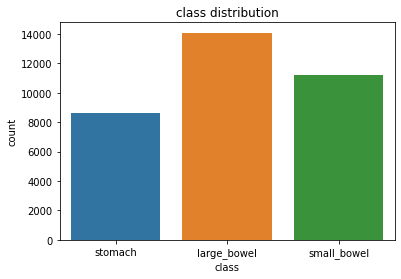

In [ ]:
sns.countplot(masks_without_na['class'])
plt.title('class distribution')
plt.xlabel('class');

In [ ]:
# Checking how many images with masks have 1/2/3 classes.
masks_without_na.groupby(by = 'id').agg(number_of_classes = ('class', 'count')).value_counts()

number_of_classes
2                    10921
3                     3201
1                     2468
dtype: int64

In [ ]:
numbaer_positive_samples = masks_without_na.groupby(by = 'id').agg(number_of_classes = ('class', 'count')).count()[0]
numbaer_positive_samples

16590

We can see that only 16590 images have segementation mask.

In [ ]:
masks_without_na.groupby(by = 'id').agg(number_of_classes = ('Encoded class', 'sum')).value_counts()

number_of_classes
4                    7781
9                    3201
6                    2980
5                    2286
8                     160
1                     123
3                      59
dtype: int64

**Need to consider in the splitting phase**

1 class: 1 - large_bowel, 3 - small_bowel, 5 - stomach 

2 classes: 4 - large_bowel + small_bowel, 6 - large_bowel + stomach, 8 - small_bowel + stomach 

3 classes: 9 - all

check the distribution of days for each patient case and the distribution of scans per day

In [ ]:
number_of_days = masks_without_na.groupby(by = ['case_num']).agg(number_of_days = ('day_num', 'nunique'))
number_of_days

,number_of_days
case_num,
case101,4
case102,1
case107,3
case108,3
case11,3
...,...
case89,5
case9,3
case90,3


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


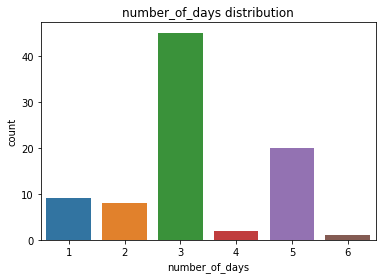

In [ ]:
sns.countplot(number_of_days['number_of_days'])
plt.title('number_of_days distribution')
plt.xlabel('number_of_days');

In [ ]:
number_of_scans = masks_without_na.groupby(by = ['case_num','day_num']).agg(number_of_scans = ('scan_num', 'count'))
number_of_scans

number_of_scans
case_num day_num                 
case101  day20                 95
         day22                124
         day26                122
         day32                110
case102  day0                 112
...                           ...
case90   day0                 137
         day22                113
         day29                107
case91   day0                 130
case92   day0                 136

[274 rows x 1 columns]

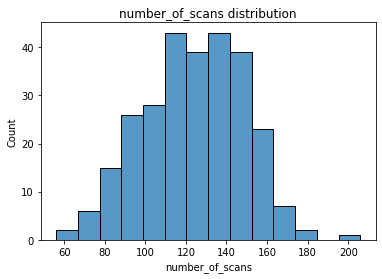

In [ ]:
sns.histplot(number_of_scans['number_of_scans'])
plt.title('number_of_scans distribution')
plt.xlabel('number_of_scans');

In [ ]:
masks_without_na.groupby(by = ['day_num']).agg(number_of_scans = ('scan_num', 'count')).shape

(35, 1)

In [ ]:
masks.groupby(by = ['day_num']).agg(number_of_scans = ('scan_num', 'count')).shape

(35, 1)

We can see that we have segmentation mask for each patient and for each day.

## Exploring the images + segemention

### one image

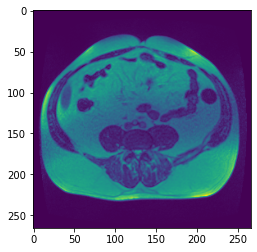

In [ ]:
# using matplolib, the values in the image in the range [0,1]
path = '/content/train/case123/case123_day0/scans/slice_0111_266_266_1.50_1.50.png'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

(array([3.2495e+04, 7.0710e+03, 4.7630e+03, 6.8410e+03, 7.3890e+03,
        9.3530e+03, 2.1460e+03, 5.7300e+02, 9.9000e+01, 2.6000e+01]),
 array([0.        , 0.01159533, 0.02319066, 0.03478599, 0.04638132,
        0.05797665, 0.06957198, 0.08116731, 0.09276264, 0.10435797,
        0.1159533 ], dtype=float32),
 <a list of 10 Patch objects>)

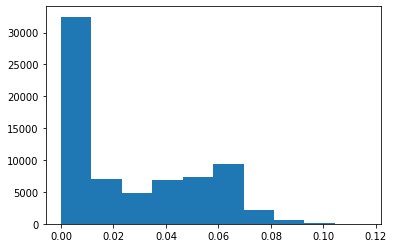

In [ ]:
plt.hist(img.flatten())

In [ ]:
img.shape

(266, 266)

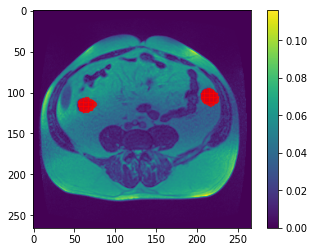

In [ ]:
# Add the segemention on the image 
lis = masks[masks.id=="case123_day0_slice_0111"].segmentation.iloc[0]
lis = [int(i) for i in lis.split(" ")]
img_size = img.shape
img_seg = np.zeros_like(img)
imgplot_seg = plt.imshow(img)
plt.colorbar()
for pos in range(0,len(lis),2):
  # Converts a flat index or array of flat indices into a tuple of coordinate arrays.
  ezer = np.unravel_index(np.arange(lis[pos],lis[pos]+lis[pos+1]),img_size) 
  plt.scatter(ezer[1],ezer[0],s=0.1,c='r') # For visualization purpose only
  img_seg[ezer[0],ezer[1]] = [1] # Create the mask
plt.show()


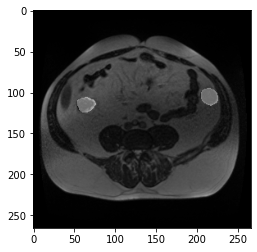

In [ ]:
plt.imshow(img, cmap='gray')
plt.imshow(img_seg, alpha=0.4, cmap='gray')

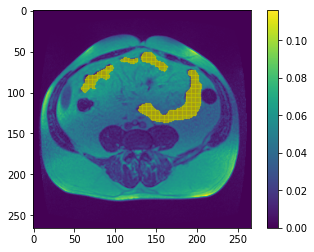

In [ ]:
lis = masks[masks.id=="case123_day0_slice_0111"].segmentation.iloc[1]
lis = [int(i) for i in lis.split(" ")]
img_size = img.shape
img_seg = np.zeros_like(img)
imgplot_seg = plt.imshow(img)
plt.colorbar()
for pos in range(0,len(lis),2):
  ezer = np.unravel_index(np.arange(lis[pos],lis[pos]+lis[pos+1]),img_size)
  plt.scatter(ezer[1],ezer[0],s=0.1,c='y')
  img_seg[ezer[0],ezer[1]] = [2]
# img_seg = img_seg.reshape(img.shape)
plt.show()


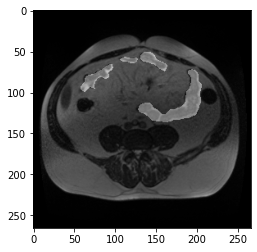

In [ ]:
plt.imshow(img, cmap='gray')
plt.imshow(img_seg, alpha=0.4, cmap='gray')

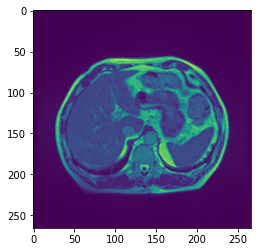

In [ ]:
path = '/content/train/case149/case149_day0/scans/slice_0071_266_266_1.50_1.50.png'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

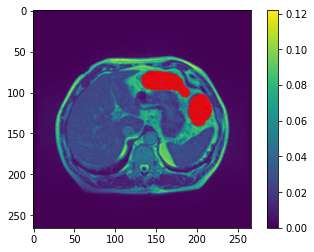

In [ ]:
# Add the segemention on the image 
lis = masks[masks.id=="case149_day0_slice_0071"].segmentation.iloc[0]
lis = [int(i) for i in lis.split(" ")]
img_size = img.shape
img_seg = np.zeros_like(img)
imgplot_seg = plt.imshow(img)
plt.colorbar()
for pos in range(0,len(lis),2):
  # Converts a flat index or array of flat indices into a tuple of coordinate arrays.
  ezer = np.unravel_index(np.arange(lis[pos],lis[pos]+lis[pos+1]),img_size) 
  plt.scatter(ezer[1],ezer[0],s=0.1,c='r') # For visualization purpose only
  img_seg[ezer[0],ezer[1]] = [1] # Create the mask
plt.show()

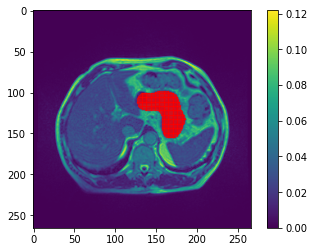

In [ ]:
# Add the segemention on the image 
lis = masks[masks.id=="case149_day0_slice_0071"].segmentation.iloc[2]
lis = [int(i) for i in lis.split(" ")]
img_size = img.shape
img_seg = np.zeros_like(img)
imgplot_seg = plt.imshow(img)
plt.colorbar()
for pos in range(0,len(lis),2):
  # Converts a flat index or array of flat indices into a tuple of coordinate arrays.
  ezer = np.unravel_index(np.arange(lis[pos],lis[pos]+lis[pos+1]),img_size) 
  plt.scatter(ezer[1],ezer[0],s=0.1,c='r') # For visualization purpose only
  img_seg[ezer[0],ezer[1]] = [1] # Create the mask
plt.show()

### Go through all the pictures and check that they are not corrupt.

In [ ]:
filelist = []
PATH = '/content/train/'

for root, dirs, files in os.walk(PATH):
	for file in files:
        #append the file name to the list
		filelist.append(os.path.join(root,file))
df_path = pd.DataFrame(sorted(filelist),columns=['path'])
df_path.head()

,path
0,/content/train/case101/case101_day20/scans/sli...
1,/content/train/case101/case101_day20/scans/sli...
2,/content/train/case101/case101_day20/scans/sli...
3,/content/train/case101/case101_day20/scans/sli...
4,/content/train/case101/case101_day20/scans/sli...


In [ ]:
df_ezer = df_path.path.str.split('/', expand=True)
df_ezer

,0,1,2,3,4,5,6
0,,content,train,case101,case101_day20,scans,slice_0001_266_266_1.50_1.50.png
1,,content,train,case101,case101_day20,scans,slice_0002_266_266_1.50_1.50.png
2,,content,train,case101,case101_day20,scans,slice_0003_266_266_1.50_1.50.png
3,,content,train,case101,case101_day20,scans,slice_0004_266_266_1.50_1.50.png
4,,content,train,case101,case101_day20,scans,slice_0005_266_266_1.50_1.50.png
...,...,...,...,...,...,...,...
38491,,content,train,case92,case92_day0,scans,slice_0140_266_266_1.50_1.50.png
38492,,content,train,case92,case92_day0,scans,slice_0141_266_266_1.50_1.50.png
38493,,content,train,case92,case92_day0,scans,slice_0142_266_266_1.50_1.50.png
38494,,content,train,case92,case92_day0,scans,slice_0143_266_266_1.50_1.50.png


In [ ]:
df_ezer2 = df_ezer.loc[:,6].str.split('_', expand=True)
df_ezer2

,0,1,2,3,4,5
0,slice,0001,266,266,1.50,1.50.png
1,slice,0002,266,266,1.50,1.50.png
2,slice,0003,266,266,1.50,1.50.png
3,slice,0004,266,266,1.50,1.50.png
4,slice,0005,266,266,1.50,1.50.png
...,...,...,...,...,...,...
38491,slice,0140,266,266,1.50,1.50.png
38492,slice,0141,266,266,1.50,1.50.png
38493,slice,0142,266,266,1.50,1.50.png
38494,slice,0143,266,266,1.50,1.50.png


In [ ]:
df_path.path = df_path.path.astype(str)
df_path['image_shape'] = list(zip(df_ezer2.loc[:,2],df_ezer2.loc[:,3]))#, df_ezer.loc[:,4]+"_"+df_ezer2.loc[:,0]+"_"+df_ezer2.loc[:,1]]

In [ ]:
df_path['id_img'] = df_ezer.loc[:,4]+"_"+df_ezer2.loc[:,0]+"_"+df_ezer2.loc[:,1]

In [ ]:
df_path

,path,image_shape,id_img
0,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0001
1,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0002
2,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0003
3,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0004
4,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0005
...,...,...,...
38491,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0140
38492,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0141
38493,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0142
38494,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0143


We can see that not all the scans in the same size

In [ ]:
# check how many images have for each size
dic={}
for i in range(df_path.shape[0]):
  if df_path.image_shape[i] in dic:
      dic[df_path.image_shape[i]] += 1
  else:
    dic[df_path.image_shape[i]] = 1
dic

{('234', '234'): 144,
 ('266', '266'): 25920,
 ('276', '276'): 1200,
 ('360', '310'): 11232}

In [ ]:
# check how many images have for each size that have a mask
dic={}
for i in range(df_path.shape[0]):
  if (masks_without_na.id==df_path.id_img[i]).any():
    if df_path.image_shape[i] in dic:
      dic[df_path.image_shape[i]] += 1
    else:
      dic[df_path.image_shape[i]] = 1
dic

{('234', '234'): 56,
 ('266', '266'): 10955,
 ('276', '276'): 718,
 ('360', '310'): 4861}

In [ ]:
# Set some parameters fro the model
im_width = 256
im_height = 256

In [ ]:
print("No. of images = ", len(filelist))

No. of images =  38496


In [ ]:
def create_mask(id_img, img_shape):
  img_seg = np.zeros((img_shape[0],img_shape[1],3))
  lis = masks[masks.id==id_img].segmentation
  for i in range(3):
      if not isinstance(lis.iloc[i], str) :
        continue
      lis_ezer = [int(i) for i in lis.iloc[i].split(" ")]
      for pos in range(0,len(lis_ezer),2):
        ezer = np.unravel_index(np.arange(lis_ezer[pos],lis_ezer[pos]+lis_ezer[pos+1]),img_shape)
        img_seg[ezer[0],ezer[1],i] = [i+1]
  return img_seg

In [ ]:
def plot_image_mask(img,img_seg, id_img):
  plt.imshow(img)
  plt.imshow(img_seg, alpha=0.4)
  plt.title(id_img)

In [ ]:
def image_by_path(path):  
    img = imread(path)/255.0
    id_img = df_path[df_path.path==path].id_img.iloc[0]
    img_seg = create_mask(id_img, img.shape)
    img = resize(img, (im_height, im_width), mode = 'constant', preserve_range = True)
    img_seg = resize(img_seg, (im_height, im_width), mode = 'constant', preserve_range = True)
    return (img,img_seg, id_img)

In [ ]:
def generator_images(filelist):
  for path in filelist:
     yield image_by_path(path)

In [ ]:
image_gen=generator_images(sorted(filelist))

In [ ]:
img,img_seg, id_img = next(image_gen)

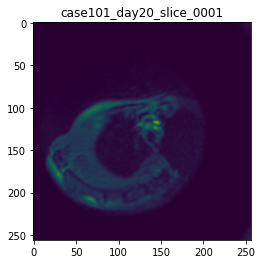

In [ ]:
plot_image_mask(img,img_seg, id_img)

In [ ]:
df_path

,path,image_shape,id_img
0,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0001
1,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0002
2,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0003
3,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0004
4,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0005
...,...,...,...
38491,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0140
38492,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0141
38493,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0142
38494,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0143


In [ ]:
df_path.id_img = df_path.id_img.astype(str)
df_path[['case_num','day_num','slice','scan_num']] = df_path['id_img'].str.split('_',n=3, expand=True)
df_path.drop(['slice'], axis = 1, inplace = True) 

In [ ]:
df_path

,path,image_shape,id_img,case_num,day_num,scan_num
0,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0001,case101,day20,0001
1,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0002,case101,day20,0002
2,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0003,case101,day20,0003
3,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0004,case101,day20,0004
4,/content/train/case101/case101_day20/scans/sli...,"(266, 266)",case101_day20_slice_0005,case101,day20,0005
...,...,...,...,...,...,...
38491,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0140,case92,day0,0140
38492,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0141,case92,day0,0141
38493,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0142,case92,day0,0142
38494,/content/train/case92/case92_day0/scans/slice_...,"(266, 266)",case92_day0_slice_0143,case92,day0,0143


In [ ]:
filelist_case = df_path[df_path['case_num']=='case74'].path.tolist()
image_gen_case = generator_images(filelist_case[:20])

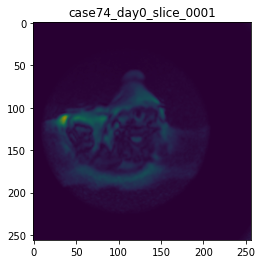

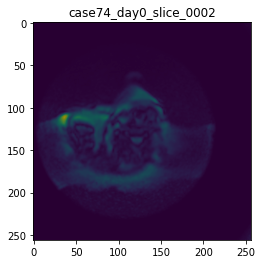

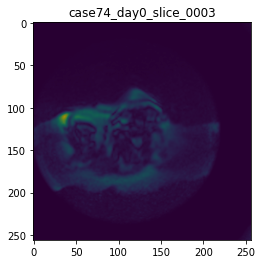

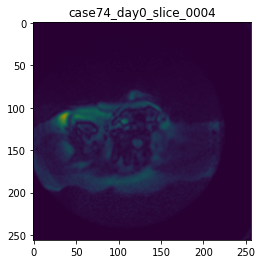

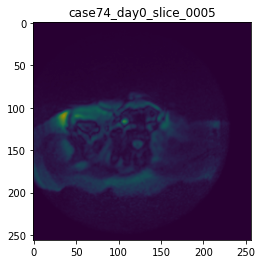

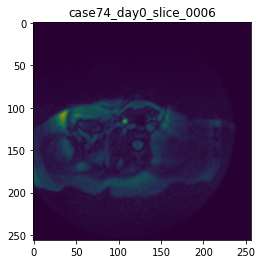

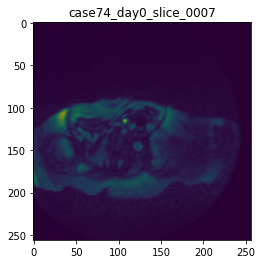

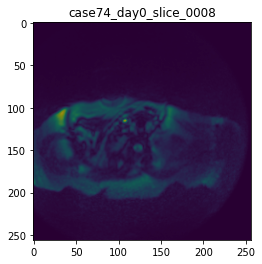

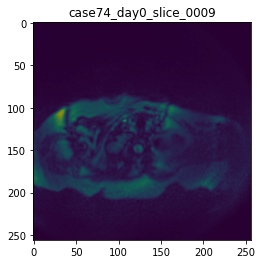

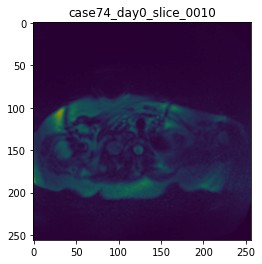

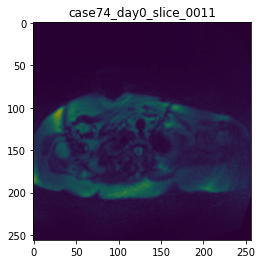

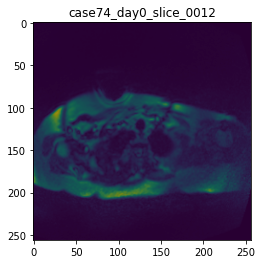

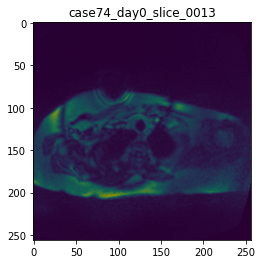

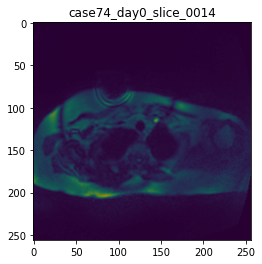

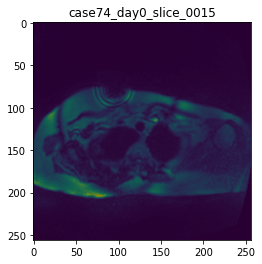

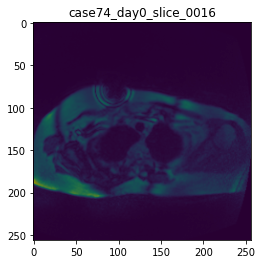

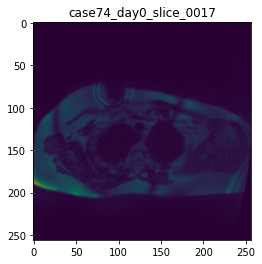

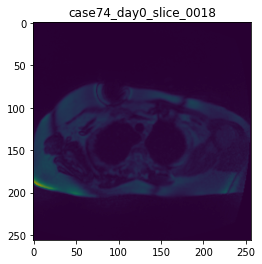

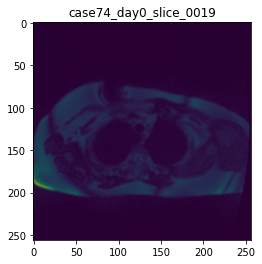

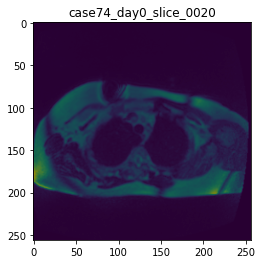

In [ ]:
for img,img_seg, id_img in image_gen_case:
    plt.figure()
    plot_image_mask(img,img_seg, id_img)
    plt.show()

things to do:

EDA
* for visualization:
create video from scans of same day

* check the distribution of the size of the three organs

* check the distribution of the location of the three organs

* check that the masks for the different organs do not overlap

* check the beginning and the end of the mask corresponding to the image shape 

* check the distribution of values of the image; check that not have outliers values(too high corresponding to the other).

* check that the all files are readable

* check the class for each pixel and see the distribution and if we have imbalance data

* check if classes overlap

Split
* split
by GroupKfold once by case, second by day

Pre-processing:
re-sizing
* check the input size of the 'unit' model.
*check for competition rules.


Model
* maximum voting
* unet
  - first using only the positive examples
  - second using all the examples

Model Evaluation
* create the metric

improvements to the model:

* Data Augmentation: check what is appropriate for medical scans(MRI)
* class weights: especially if the model predict only the majority class

General:
* check the extra